# Matching the C. elegans connectomes
Here we compare performance on matching the C. elegans male and hermaphrodite
chemical connectomes. The connectomes have been reduced to the intersection of their
largest connected components prior to loading in, so they share the same node set.

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import quadratic_assignment

from pkg.data import load_c_elegans
from pkg.gmp import quadratic_assignment_ot
from pkg.io import savefig

t0 = time.time()


def stashfig(name, **kwargs):
    savefig(name, foldername="elegans", print_out=False, **kwargs)

## Load the data

In [2]:
male_adj, herm_adj, cell_names = load_c_elegans()

## Run the graph matching experiment

In [3]:

correct_inds = np.arange(len(herm_adj))


def compute_match_ratio(inds, correct_inds):
    matched = inds == correct_inds
    return np.mean(matched)


vanilla_options = dict(maximize=True, maxiter=150, tol=1e-5, shuffle_input=True)
goat_options = dict(maximize=True, maxiter=150, tol=1e-5, shuffle_input=True)
currtime = time.time()
n_init = 50
rows = []
for i in range(n_init):
    res = quadratic_assignment(male_adj, herm_adj, options=vanilla_options)
    res["match_ratio"] = compute_match_ratio(res["col_ind"], correct_inds)
    res["method"] = "vanilla"
    res["reg"] = "None"
    rows.append(res)
    for reg in [100, 300, 500, 700]:  # above 700 usually breaks
        goat_options["reg"] = reg
        res = quadratic_assignment_ot(male_adj, herm_adj, options=goat_options)
        res["match_ratio"] = compute_match_ratio(res["col_ind"], correct_inds)
        res["method"] = "goat"
        res["reg"] = reg
        rows.append(res)
print(f"{time.time() - currtime:.3f} seconds elapsed.")
results = pd.DataFrame(rows)
results.head()

603.042 seconds elapsed.


,col_ind,fun,nit,match_ratio,method,reg
0,"[355, 354, 66, 3, 4, 62, 6, 7, 8, 9, 10, 11, 1...",466202.0,50,0.657277,vanilla,None
1,"[289, 0, 275, 3, 281, 75, 10, 38, 8, 9, 285, 1...",413488.0,22,0.528169,goat,100
2,"[42, 228, 2, 3, 4, 5, 6, 38, 8, 10, 285, 11, 1...",449849.0,42,0.591549,goat,300
3,"[1, 163, 2, 3, 4, 267, 9, 38, 8, 10, 285, 12, ...",454419.0,31,0.586854,goat,500
4,"[2, 163, 62, 3, 4, 75, 5, 38, 8, 10, 9, 12, 11...",469003.0,38,0.624413,goat,700


## Plot results

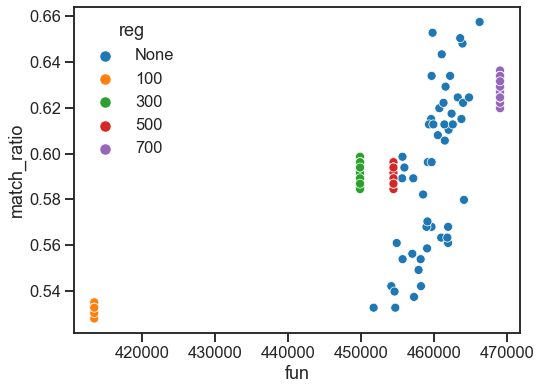

In [4]:
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=results, x="fun", y="match_ratio", hue="reg", ax=ax)
stashfig("elegans-fun-vs-match")

## End

In [5]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:10:04.088688
Completed at 2021-03-16 10:08:37.867158
----
